Epoch 1/10, Loss: 0.0271, Accuracy: 0.9257
Epoch 2/10, Loss: 0.0247, Accuracy: 0.9324
Epoch 3/10, Loss: 0.0236, Accuracy: 0.9363
Epoch 4/10, Loss: 0.0238, Accuracy: 0.9361
Epoch 5/10, Loss: 0.0241, Accuracy: 0.9328
Epoch 6/10, Loss: 0.0244, Accuracy: 0.9345
Epoch 7/10, Loss: 0.0243, Accuracy: 0.9376
Epoch 8/10, Loss: 0.0242, Accuracy: 0.9353
Epoch 9/10, Loss: 0.0231, Accuracy: 0.9385
Epoch 10/10, Loss: 0.0237, Accuracy: 0.9343
Test Loss: 0.0333, Test Accuracy: 0.8954
Normalized confusion matrix
[[9.62244898e-01 0.00000000e+00 1.32653061e-02 0.00000000e+00
  1.02040816e-03 6.12244898e-03 1.12244898e-02 1.02040816e-03
  5.10204082e-03 0.00000000e+00]
 [0.00000000e+00 9.89427313e-01 3.52422907e-03 0.00000000e+00
  0.00000000e+00 8.81057269e-04 2.64317181e-03 8.81057269e-04
  2.64317181e-03 0.00000000e+00]
 [5.81395349e-03 8.72093023e-03 9.41860465e-01 0.00000000e+00
  1.35658915e-02 1.93798450e-03 1.16279070e-02 6.78294574e-03
  9.68992248e-03 0.00000000e+00]
 [0.00000000e+00 1.48514851e-

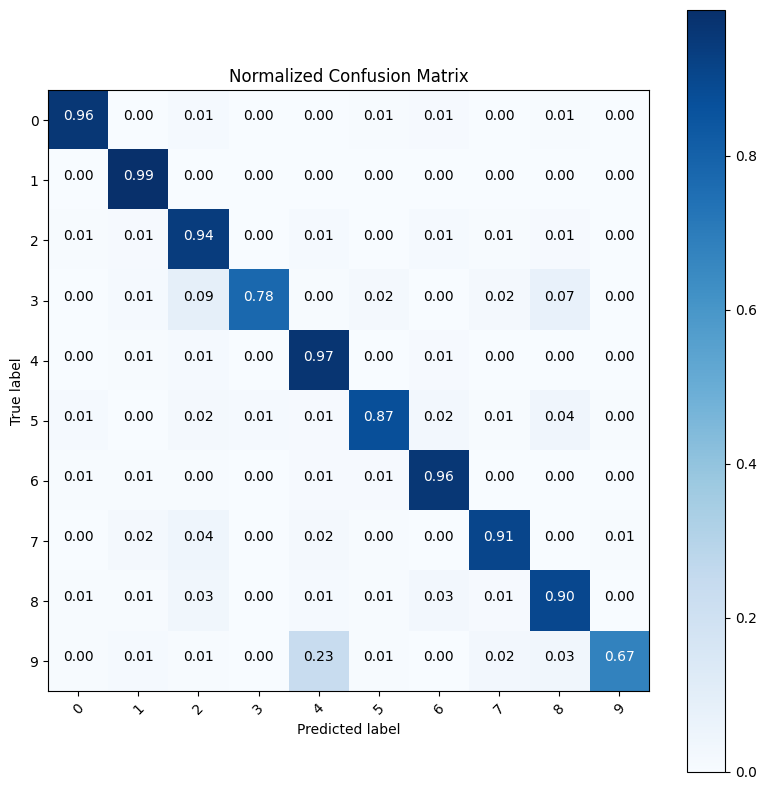

In [1]:
import itertools
import os

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

class BatchNorm:
    def __init__(self, size, momentum=0.9, epsilon=1e-8):
        self.size = size
        self.momentum = momentum
        self.epsilon = epsilon
        self.gamma = np.ones(size)
        self.beta = np.zeros(size)
        self.running_mean = np.zeros(size)
        self.running_var = np.ones(size)

    def forward(self, x, training):
        if training:
            # Calculate batch statistics
            self.batch_mean = np.mean(x, axis=0)
            self.batch_var = np.var(x, axis=0)

            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var

            # Normalize the inputs
            normalized = (x - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)
        else:
            # Use the running statistics for inference
            normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        # Apply scaling and shifting
        out = self.gamma * normalized + self.beta
        return out


class TwoLayerMLP:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation='relu', reg_lambda=0.0, reg_type='l2'):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.activation = activation # choose activation
        self.reg_lambda = reg_lambda
        self.reg_type = reg_type

        # Initialize weights and biases for each layer
        self.weights = {
            'W1': np.random.randn(input_size, hidden_size1) * np.sqrt(2.0 / input_size),
            'W2': np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2.0 / hidden_size1),
            'W3': np.random.randn(hidden_size2, output_size) * np.sqrt(2.0 / hidden_size2)
        }
        self.biases = {
            'b1': np.zeros((1, hidden_size1)),
            'b2': np.zeros((1, hidden_size2)),
            'b3': np.zeros((1, output_size))
        }

        # Add batch normalization layers
        self.batch_norm1 = BatchNorm(hidden_size1)
        self.batch_norm2 = BatchNorm(hidden_size2)

        # Adam optimization parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.m = {key: np.zeros_like(val) for key, val in self.weights.items()}
        self.v = {key: np.zeros_like(val) for key, val in self.weights.items()}
        self.t = 0

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, z):
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            raise ValueError(f"Invalid activation function: {self.activation}")

    def forward(self, X, training=True):
        # Forward pass
        z1 = np.dot(X, self.weights['W1']) + self.biases['b1']
        a1 = self.batch_norm1.forward(self.activate(z1), training)
        # a1 = self.activate(z1)
        # a1 = self.relu(z1)
        z2 = np.dot(a1, self.weights['W2']) + self.biases['b2']
        a2 = self.batch_norm2.forward(self.activate(z2), training)
        # a2 = self.activate(z2)
        logits = np.dot(a2, self.weights['W3']) + self.biases['b3']
        output = self.softmax(logits)
        return a1, a2, output, logits

    def backward(self, X, y, a1, a2, output, logits, learning_rate):
        # Backpropagation
        m = X.shape[0]  # Number of examples

        # Compute gradients
        delta4 = output - y
        dW3 = np.dot(a2.T, delta4) / m
        db3 = np.sum(delta4, axis=0, keepdims=True) / m
        delta3 = np.dot(delta4, self.weights['W3'].T) * (a2 > 0)
        dW2 = np.dot(a1.T, delta3) / m
        db2 = np.sum(delta3, axis=0, keepdims=True) / m
        delta2 = np.dot(delta3, self.weights['W2'].T) * (a1 > 0)
        dW1 = np.dot(X.T, delta2) / m
        db1 = np.sum(delta2, axis=0, keepdims=True) / m

        # Apply regularization
        if self.reg_type == 'l1':
            dW3 += self.reg_lambda * np.sign(self.weights['W3'])
            dW2 += self.reg_lambda * np.sign(self.weights['W2'])
            dW1 += self.reg_lambda * np.sign(self.weights['W1'])
        elif self.reg_type == 'l2':
            dW3 += self.reg_lambda * self.weights['W3']
            dW2 += self.reg_lambda * self.weights['W2']
            dW1 += self.reg_lambda * self.weights['W1']
        elif self.reg_type == 'elastic_net':
            dW3 += self.reg_lambda * (np.sign(self.weights['W3']) + self.weights['W3'])
            dW2 += self.reg_lambda * (np.sign(self.weights['W2']) + self.weights['W2'])
            dW1 += self.reg_lambda * (np.sign(self.weights['W1']) + self.weights['W1'])

        # Update weights and biases using Adam optimizer
        self.t += 1
        for key in self.weights.keys():
            # Update biased first moment estimate
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * locals()['d' + key]
            # Update biased second raw moment estimate
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (locals()['d' + key] ** 2)
            # Compute bias-corrected first moment estimate
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            # Update parameters
            self.weights[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.biases['b' + key[1:]] -= learning_rate * locals()['db' + key[1:]]

    def train(self, X, y, epochs=10, batch_size=32, learning_rate=0.001):
        num_examples = X.shape[0]
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(num_examples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Mini-batch training
            for i in range(0, num_examples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Forward pass
                a1, a2, output, logits = self.forward(X_batch)

                # Backward pass
                self.backward(X_batch, y_batch, a1, a2, output, logits, learning_rate)

            # Compute loss and accuracy for each epoch
            _, _, output, _ = self.forward(X)
            loss = -np.mean(y * np.log(output + 1e-9))
            accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    def test(self, X_test, y_test_one_hot):
        _, _, test_output, _ = self.forward(X_test)
        test_loss = -np.mean(y_test_one_hot * np.log(test_output + 1e-9))
        test_accuracy = np.mean(np.argmax(test_output, axis=1) == np.argmax(y_test_one_hot, axis=1))
        return test_loss, test_accuracy

    def test(self, X_test, y_test_one_hot):
        _, _, test_output, _ = self.forward(X_test, training=False)
        test_loss = -np.mean(y_test_one_hot * np.log(test_output + 1e-9))
        test_accuracy = np.mean(np.argmax(test_output, axis=1) == np.argmax(y_test_one_hot, axis=1))

        # Compute confusion matrix
        y_pred = np.argmax(test_output, axis=1)
        y_true = np.argmax(y_test_one_hot, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        return test_loss, test_accuracy, cm


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 指定数据集保存的目录路径
data_dir = 'data'

# 如果目录不存在,则创建目录
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Load MNIST dataset
# 尝试从指定目录中读取数据集
try:
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'), allow_pickle=True)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'), allow_pickle=True)
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'), allow_pickle=True)
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'), allow_pickle=True)
except FileNotFoundError:
    # 如果数据集文件不存在,则下载并保存
    mnist = fetch_openml('mnist_784', as_frame=False, data_home=data_dir)
    X_train, y_train = mnist.data[:60000], mnist.target[:60000]
    X_test, y_test = mnist.data[60000:], mnist.target[60000:]

    # 保存数据集到指定目录
    np.save(os.path.join(data_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(data_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(data_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(data_dir, 'y_test.npy'), y_test)

# Flatten images and normalize
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = np.eye(10)[y_train.astype(int)]
y_test_one_hot = np.eye(10)[y_test.astype(int)]

# Initialize and train the model
model = TwoLayerMLP(input_size=784, hidden_size1=128, hidden_size2=64, output_size=10, activation='relu',reg_lambda=0.01, reg_type='l2')
model.train(X_train, y_train_one_hot, epochs=10, batch_size=128, learning_rate=0.001)

# Test the model
test_loss, test_accuracy, cm = model.test(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the confusion matrix
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')